In [111]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [112]:
from analysis import collection, analysis

from pathlib import Path
import json

import numpy as np
import scipy
from sklearn.decomposition import PCA
from analysis import analysis
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
from IPython.display import HTML

from matplotlib.gridspec import GridSpec

import matplotlib as mpl
mpl.rcParams.update({'axes.labelsize': 16})

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

## mean zero covariance -- sample covariance assuming mean of every spatial dimension is 0

[ 1.   2.   2.5  5.  10. ]
[ 1.   2.   nan  2.5  5.  10. ]


array([4., 3., 2., 1.])

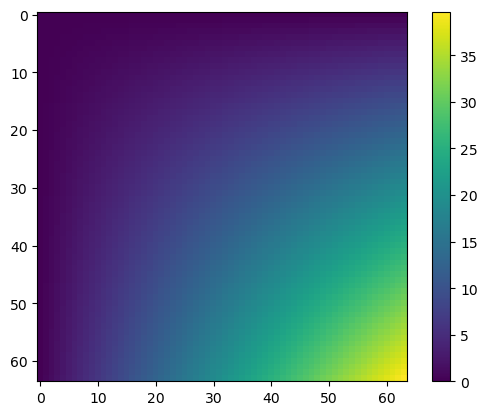

In [130]:
ROOT_RAWDATA_PATH = Path("/Users/spencer/motor-control/data/rawdata/")
ROOT_METADATA_PATH = Path("/Users/spencer/motor-control/data/metadata/")

def remove_nan_rows(x, return_idx=False):
    mask = ~np.isnan(x).any(axis=1)
    if return_idx:
        return x[mask, :], np.where(~mask)[0]
    else:
        return x[mask, :]

def remove_nan_cols(x):
    mask = ~np.isnan(x).any(axis=0)
    return x[mask]

def get_movement_filenames(collection_name, subject_name, task_name, session_name):
    filenames = []
    with open(ROOT_METADATA_PATH / collection_name / "natural_movement.json") as fp:
        movements = json.load(fp)["movements"]

    for movement in movements:
        directory = (
            ROOT_RAWDATA_PATH
            / collection_name
            / subject_name
            / task_name
            / session_name
        )
        prefix = str(ROOT_RAWDATA_PATH / collection_name / subject_name / task_name / session_name / movement)
        for filename in directory.iterdir(): 
            if str(filename).startswith(prefix) and str(filename).split(".")[-1] == "bin":
                filenames.append(filename)
    return filenames

def load_movement_emg(filename):
    return np.fromfile(filename, dtype=np.int32).reshape(-1, 68).astype(np.float32)[:,:64]

def make_kernel(kernel_length, cutoff_hz, sample_rate_hz, mode="lowpass"):
    # based on https://github.com/bonsai-rx/bonsai/blob/9c4db22dfa43a7b20fb8de7cb4eb079b19cfa027/Bonsai.Dsp/FrequencyFilter.cs#L153
    # Low-pass windowed-sinc filter: http://www.dspguide.com/ch16/4.htm
    cutoffRadians = 2 * np.pi * cutoff_hz / sample_rate_hz
    kernel = np.zeros((kernel_length + 1, 1))
    for i in range(kernel_length):
        normalizer = i - (kernel_length // 2)
        if normalizer == 0: 
            kernel[i] = cutoffRadians
        else:
            kernel[i] = np.sin(cutoffRadians * normalizer) / normalizer

        # Blackman window: http://www.dspguide.com/ch16/1.htm
        kernel[i] = kernel[i] * (0.42 - 0.5 * np.cos(2 * np.pi * i / kernel_length) + 0.08 * np.cos(4 * np.pi * i / kernel_length))

    # Normalize for unit gain
    sum = np.sum(kernel)
    kernel /= sum

    if mode == "highpass":
        kernel *= -1
        # add unit impulse to the center of the kernel
        # in freq domain:
        # k_hp(f) = 1 - k_lp(f)
        kernel[(kernel.shape[0]) // 2] += 1

    return kernel[:-1]

# k = make_kernel(500, 5, 2000)
# plt.plot(k)

def highpass(a):
    highpass_kernel = make_kernel(250, 0.1, 2000, mode='highpass')
    # cut off the end where it's extended for the "full" convolution
    return scipy.signal.convolve2d(a, highpass_kernel, mode="full", boundary="symm")[:-highpass_kernel.shape[0]+2]

def standardize(a, var):
    return (var @ a.T).T

def rectify(a):
    return np.abs(a)

def lowpass(a):
    lowpass_kernel = make_kernel(750, 5.0, 2000, mode='lowpass')
    return scipy.signal.convolve2d(a, lowpass_kernel, mode="full", boundary="symm")[:-lowpass_kernel.shape[0]+2]

def subsample(a):
    return a[::10, :]

def filter_emg(a, var):
    if a.shape[1] != 64:
        raise ValueError(f"incorrect shape for input array: {a.shape}")
    return subsample(lowpass(rectify(standardize(highpass(a), var))))


def find_nat_movement_active_indices(sig, std_multiple=1.0, min_indices=10):
    assert sig.shape[1] == 64
    sig_norms = np.linalg.norm(sig,axis=1)

    # find location of min trajectory norm (closest to zero)
    low_point = np.argmin(sig_norms)

    # stddev of the spatial norms
    sig_norm_std = np.std(sig_norms)

    # compute the threshold, mean of a short range around the low point
    mean_norm_threshold = np.mean(
        sig_norms[np.max([0, low_point - 5]) : low_point + 5], axis=0
    )

    # mask -- one std above the lowest norm point
    mask = sig_norms > mean_norm_threshold + sig_norm_std * std_multiple

    # return the indices
    if np.sum(mask) < min_indices:
        indices = np.arange(sig.shape[0])[-min_indices:]
    else:
        indices = np.arange(sig.shape[0])[mask]
    return indices, low_point, mean_norm_threshold

def load_movement_stack(subject):

    movement_emg = np.empty(shape=(2,14,64))
    movement_emg[:] = np.nan

    for session_idx, session_name in enumerate(["session_0", "session_1"]):
        filenames = get_movement_filenames("emg_olympics", subject.name, "natural_movement", session_name)
        for movement_idx, filename in enumerate(filenames):
            emg = load_movement_emg(filename)
            filtered = filter_emg(emg, subject.variance)
            indices, low_point, mean_norm_threshold = find_nat_movement_active_indices(filtered)
            movement_emg[session_idx, movement_idx] = np.mean(filtered[indices], axis=0)

    c = np.empty((28,movement_emg.shape[2]), dtype=movement_emg.dtype)
    c[0::2,:] = movement_emg[0]
    c[1::2,:] = movement_emg[1]

    return c 

def count_nan(data):
    return np.count_nonzero(np.isnan(data))

def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

def mean_zero_cov(data):
    assert len(data.shape) == 2
    assert data.shape[1] == 64
    return (data.T @ data) / data.shape[0]

C = mean_zero_cov(np.vstack([np.arange(64)*0.1 for _ in range(100)]))
plt.figure()
plt.imshow(C)
plt.colorbar()

def insert_into_1d(x,idx,val):
    out = np.empty(shape=x.shape[0]+1)
    out[:idx] = x[:idx]
    out[idx] = val
    if idx != x.shape[0]:
        out[idx+1:] = x[idx:]
    return out

idx = 2
val = np.nan
x = np.empty(shape=5)

print(x)
print(insert_into_1d(x, idx, val))

def subspace_projection(C, subspace):
    projection = np.empty(shape=(subspace.shape[0]))
    for i, dim in enumerate(subspace):
        projection[i] = dim.T @ C @ dim
    return projection

subspace_projection(np.diag(range(1,5)), np.fliplr(np.eye((4))))

In [7]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

## find the subject "max" activity to normalize across subjects

In [117]:
# subject_maxes = {}
# for subject_idx, subject in enumerate(c.alphabetically_sorted_subjects()):
#     emg_block = np.empty(shape=(0,64))
#     for session in subject.tasks[task_name].sorted_sessions():
#         for trial in session.sorted_trials():
#             if trial.outcome != "No Hold":
#                 emg = trial.get_filtered_emg().copy()
#                 active_emg = emg[trial.active_indices,:]
#                 emg_block = np.row_stack([emg_block, active_emg])
#     p = np.percentile(emg_block,95)
#     subject_maxes[subject.name] = p            

In [118]:
# plt.plot(list(subject_maxes.values()),"ko")

## number of hits over subjects

In [10]:
hit_fractions = {}
hit_fraction_list = []
for subject in subjects:
    trial_list = []
    for session in subject.tasks[task_name].sorted_sessions():
        trial_list.extend(list(session.sorted_trials())) 
    num_trials = len(trial_list)
    hf = (sum([outcome["hits"] for outcome in [session.outcome_counts for session in subject.tasks[task_name].sorted_sessions()]]) / num_trials)
    hit_fractions[subject.name] = hf
    hit_fraction_list.append(hf)

### subset of subjects by hits

[ 0  6 15 16 21 29 33 35 37]


(0.0, 1.0)

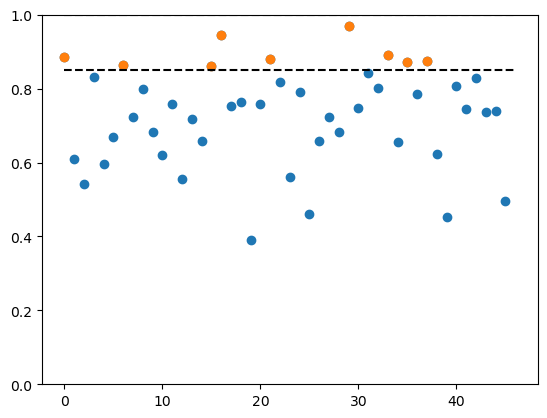

In [336]:
min_fraction = 0.85
max_fraction = 1.0
hit_fraction_mask = np.logical_and(np.array(hit_fraction_list) > min_fraction, np.array(hit_fraction_list) < max_fraction)
subject_subset_idxs = np.argwhere(hit_fraction_mask).ravel()
print(subject_subset_idxs)
plt.plot(hit_fraction_list,"o")
plt.plot(subject_subset_idxs, np.array(hit_fraction_list)[subject_subset_idxs],"o")
plt.plot([0,46],[min_fraction,min_fraction],"k--")
plt.plot([0,46],[max_fraction,max_fraction],"k--")
plt.ylim([0,1])

In [121]:
subject_subset = np.array(subjects)[hit_fraction_mask_idxs]
for subject in subject_subset:
    print(subject.name)

aeron
andy
billy
fede
jai
jesse
nicole
oriol
peterg
philip
rodrigo
tiago
viktor


## subspace projections of hit "ends" over subjects, over targets

#### collect projections along individual dimensions

## "active" emg subspace projections over subjects

In [125]:
# sanity check the nullspace is orthogonal
print(subject.decoder[-2:,:] @ subject.null_subspace.T @ np.random.random(size=(62,1)))

[[8.38003245e-08]
 [1.38519718e-07]]


(64, 64)


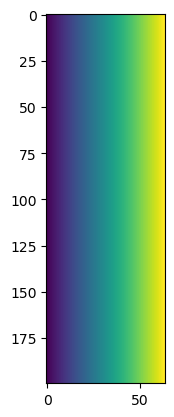

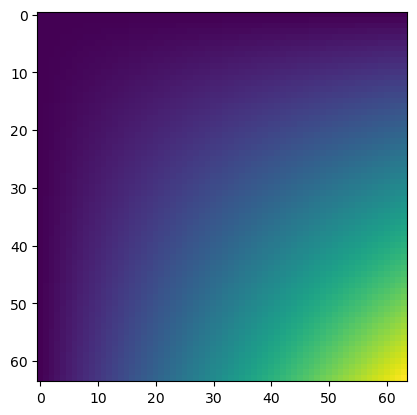

<Figure size 640x480 with 0 Axes>

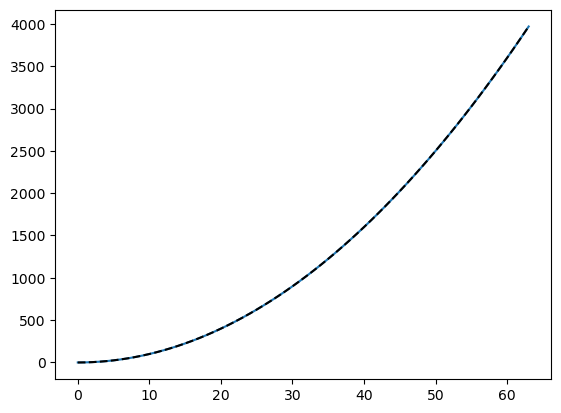

In [126]:
# sanity check covariance and subspace
d = np.row_stack([np.arange(64) for _ in range(200)])
mzc = mean_zero_cov(d)
plt.imshow(d)
plt.figure()
plt.imshow(mzc)
plt.figure()
ar = np.column_stack([np.arange(64) for _ in range(64)])
print(ar.shape)
t = np.eye(64)[:,:2].T
n = np.eye(64)[:,2:].T
# print(mzc.shape, t.shape, n.shape)
tpr = subspace_projection(mzc, t).reshape(1,-1)
npr = subspace_projection(mzc, n).reshape(1,-1)
# print(tpr.shape, npr.shape)
plt.figure()
plt.plot(np.column_stack([tpr, npr]).T)
plt.plot([x**2 for x in range(64)],"k--")

## active emg

In [127]:
# subjects, trials, targets
active_emg_mean = np.zeros(shape=(len(subjects),45,12,64))
active_emg_mean[:] = np.nan
active_emg_covs = np.zeros(shape=(len(subjects),45,12,64,64))
active_emg_covs[:] = np.nan
active_emg_vars = np.zeros(shape=(len(subjects),45,12,64))
active_emg_vars[:] = np.nan
emg_task_vars = np.zeros(shape=(len(subjects),45,12,2))
emg_task_vars[:] = np.nan
emg_null_vars = np.zeros(shape=(len(subjects),45,12,62))
emg_null_vars[:] = np.nan

for subject_idx, subject in enumerate(subjects):
    for target_idx in range(1,13):
        # go through each trial and compute the within-trial covariance, project it
        session_idx = -1
        for session in subject.tasks[task_name].sorted_sessions():
            session_idx += 1
            for trial in session.sorted_trials():
                if trial.outcome == "No Hold":
                    continue
                if trial.target_number == target_idx:
                    emg = trial.get_filtered_emg().copy()
                    active_emg = emg[trial.active_indices, :]
                    # mean over time
                    active_emg_mean[subject_idx, session_idx, target_idx-1,:] = np.mean(active_emg, axis=0)
                    # spatial correlation
                    active_emg_cov = mean_zero_cov(active_emg)
                    active_emg_covs[subject_idx, session_idx, target_idx-1,:,:] = active_emg_cov
                    active_emg_vars[subject_idx, session_idx, target_idx-1,:] = np.diag(active_emg_cov)
                    emg_task_vars[subject_idx, session_idx, target_idx-1,:] = subspace_projection(active_emg_cov, subject.task_subspace)
                    emg_null_vars[subject_idx, session_idx, target_idx-1,:] = subspace_projection(active_emg_cov, subject.null_subspace)

## hit end means

In [334]:
subject_subset_idxs

array([ 0,  3,  6, 15, 21, 22, 31, 32, 33, 35, 37, 40, 42])

In [128]:
NUM_ENDPOINTS = 3
MIN_HITS = 3

# get emg ending activity means over hit trials for each target
hit_ends = np.ones(shape=(len(subjects),45,12,64))
hit_ends[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    for target_no in range(1,13):
        for session_idx, session in enumerate(list(subject.tasks[task_name].sorted_sessions())):
            for trial in session.sorted_trials():
                if trial.target_number == target_no:
                    if trial.outcome == "Hit":
                        hit_ends[subject_idx,session_idx,target_no-1,:] = np.mean(trial.get_filtered_emg()[-NUM_ENDPOINTS:,:], axis=0)

In [17]:
# null space is nearly identity for its channel -- projection is effectively sum of that channel covariance
# plt.imshow(np.column_stack([subject.task_subspace.T, subject.decoder[-2:,:].T]))
# plt.colorbar()  
# plt.figure()
# plt.plot(subject.null_subspace[0])

## plot hit ends and trial means for a single subject

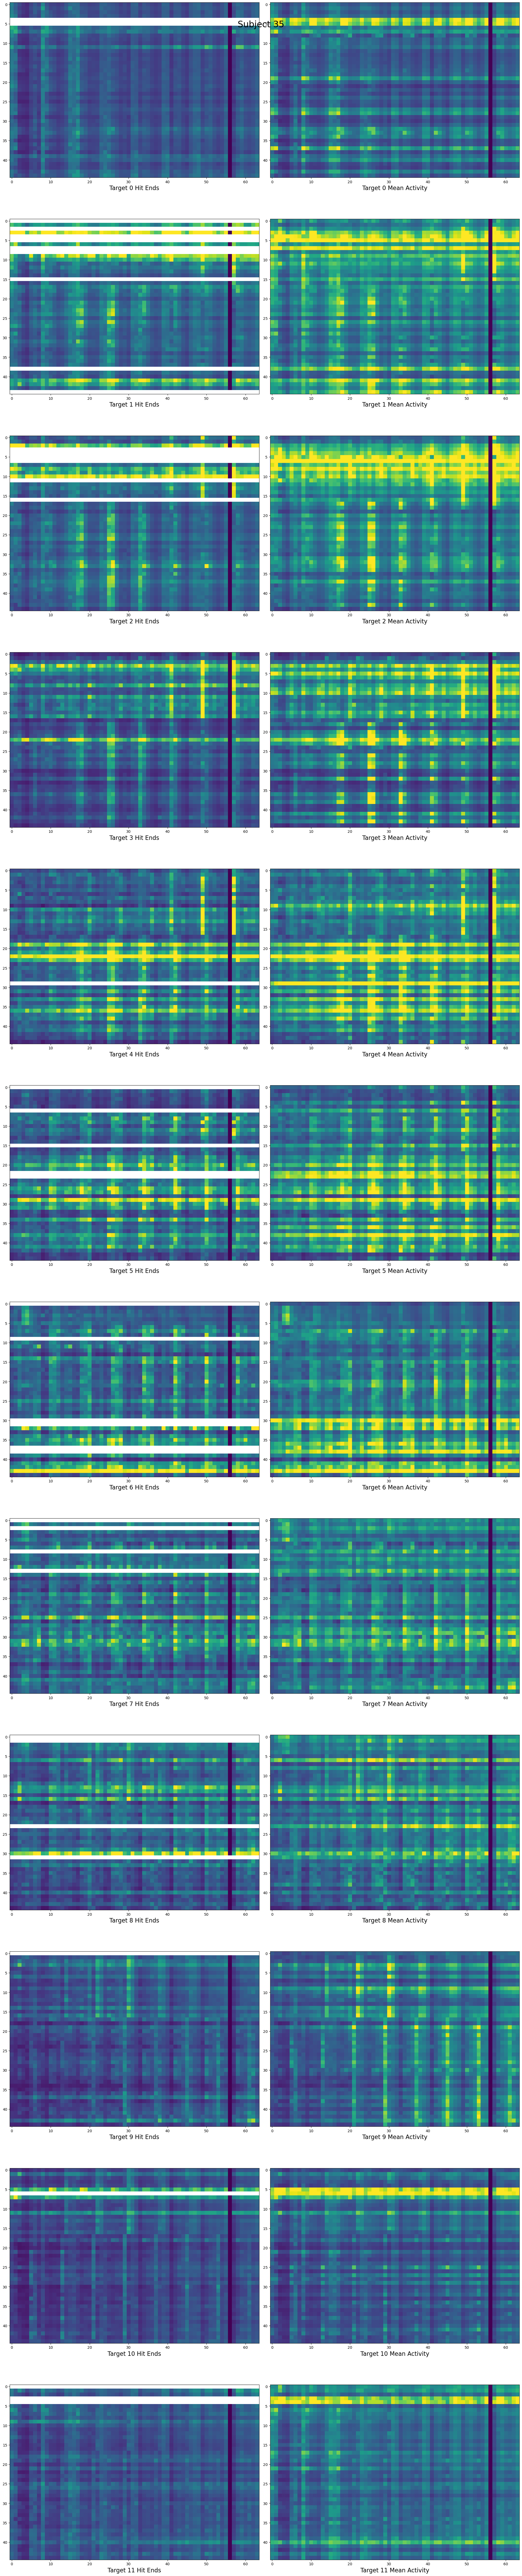

In [135]:
subject_idx = 35
vmax = 1.5

fig, ax = plt.subplots(12,2,figsize=(20,100))
for target_idx in range(12):
    ax[target_idx,0].imshow(hit_ends[subject_idx,:,target_idx,:],vmin=0,vmax=vmax)
    ax[target_idx,1].imshow(active_emg_mean[subject_idx,:,target_idx,:],vmin=0,vmax=1)
    ax[target_idx,0].set_xlabel(f"Target {target_idx} Hit Ends")
    ax[target_idx,1].set_xlabel(f"Target {target_idx} Mean Activity")
fig.suptitle(f"Subject {subject_idx}", fontsize=24)
fig.tight_layout()

## active emg covariance trace over subjects (total variance within trial) -- plotted with targets stacked, over blocks

In [173]:
subject_traces = {}
for subject_idx, subject in enumerate(subjects):
    traces = np.empty(shape=(45,12))
    for target_idx in range(12):
        covs = active_emg_covs[subject_idx,:,target_idx,:,:]
        for i, cov in enumerate(covs):
            traces[i,target_idx] = np.trace(cov)
    subject_traces[subject.name] = traces

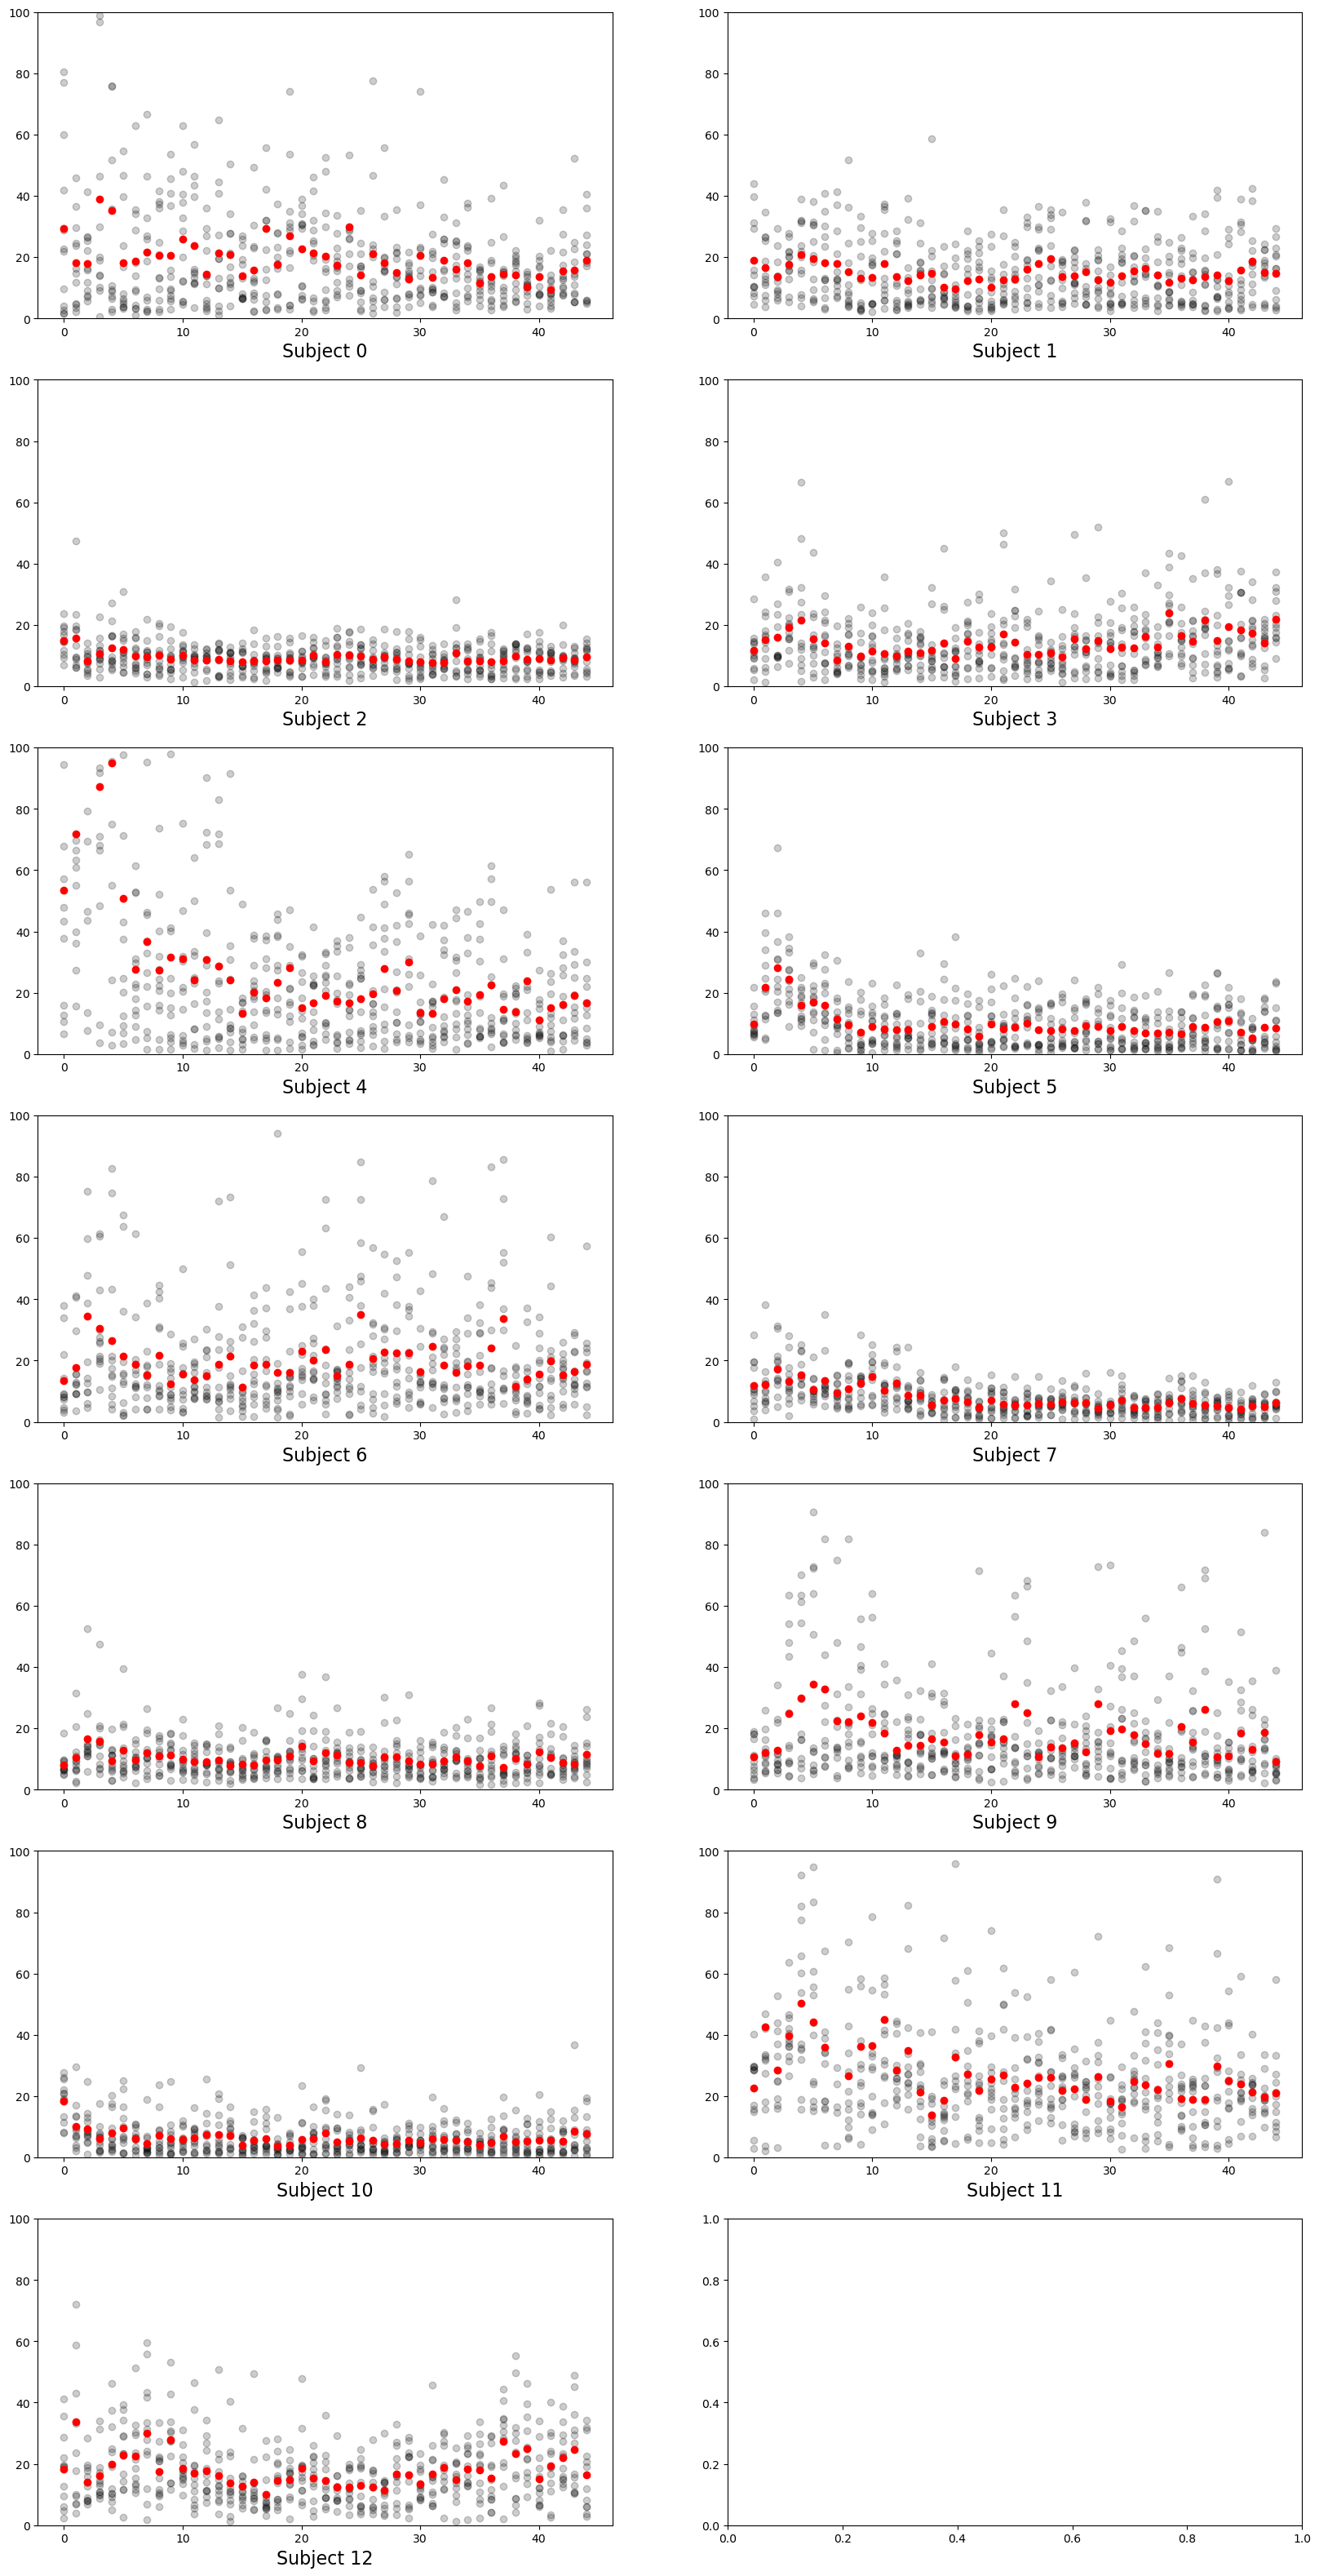

In [155]:
fig, axes = plt.subplots(int(np.ceil(len(subject_subset) / 2)),2,figsize=(20,40))
axes = axes.ravel()
for subject_idx, subject in enumerate(subject_subset):
    for target_idx in range(12):
        traces = subject_traces[subject.name]
        axes[subject_idx].plot(traces[:,target_idx], "ko", alpha=0.2)
    axes[subject_idx].plot(np.mean(traces,axis=1), "ro")
    axes[subject_idx].set_ylim([0,100])
    axes[subject_idx].set_xlabel(f"Subject {subject_idx}")

### this activity is "standardized" on each subjects' variance from the calibration task, within the quiescent period, could be that some subjects' channels are just "louder" than others

Text(0, 0.5, 'Total Trial Variance')

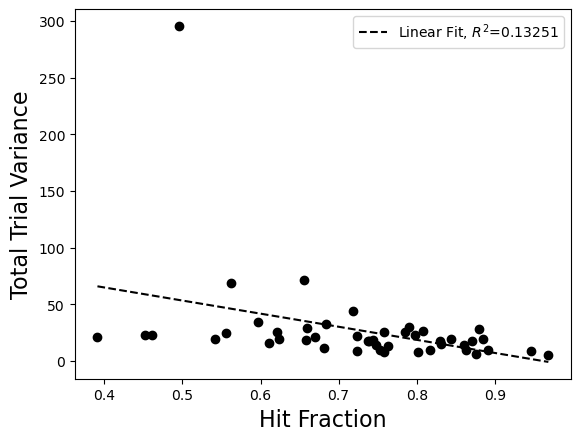

In [182]:
mean_traces = [np.nanmean(subject_traces[subject.name]) for subject in subjects]
plt.plot(hit_fraction_list, mean_traces, "ko")
x = np.linspace(np.min(hit_fraction_list), np.max(hit_fraction_list),100)
result = scipy.stats.linregress(hit_fraction_list, mean_traces)
plt.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
plt.legend()
plt.xlabel("Hit Fraction")
plt.ylabel("Total Trial Variance")

### remove the outlier?

In [176]:
print(len(mean_traces), len(hit_fraction_list))
outlier_idx = np.argmax(mean_traces)
mean_traces_no_outlier = mean_traces[:outlier_idx] + mean_traces[outlier_idx+1:]
hit_fraction_list_no_outlier = hit_fraction_list[:outlier_idx] + hit_fraction_list[outlier_idx+1:]
print(len(mean_traces_no_outlier), len(hit_fraction_list_no_outlier))

46 46
45 45


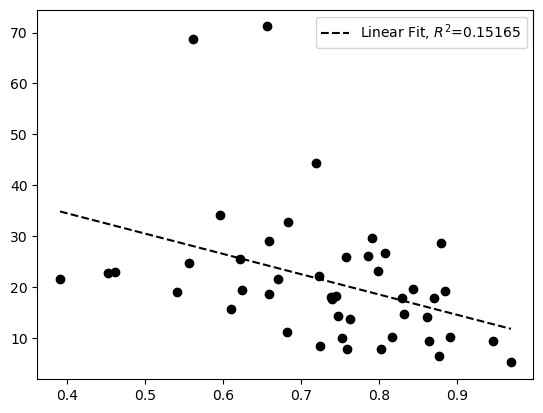

In [179]:
plt.plot(hit_fraction_list_no_outlier, mean_traces_no_outlier, "ko")
x = np.linspace(np.min(hit_fraction_list_no_outlier), np.max(hit_fraction_list_no_outlier),100)
result = scipy.stats.linregress(hit_fraction_list_no_outlier, mean_traces_no_outlier)
plt.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
plt.legend()

## hit end PCA model

In [189]:
fig, axes = plt.subplots(int(np.ceil(len(subject_subset) / 2)),2,figsize=(20,40))
axes = axes.ravel()

for subject_idx, subject in enumerate(subject_subset):
    subject_scores = np.empty(shape=(12,45))
    for target_idx in range(12):
        he = hit_ends[subject_idx,:,target_idx,:]
        he = remove_nan_rows(he)

        pca = PCA()
        pca.fit(he)
        axes[subject_idx].plot(pca.explained_variance_ratio_,"o")

        # axes[subject_idx,1].bar(x=range(64), height=pca.components_[0], alpha=0.2)
        # axes[subject_idx,1].bar(x=range(64), height=pca.components_[1], alpha=0.2)


/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


## Log-likelihoods for trial means based on hit end PCA model with 1 component

(3, 64)
(5, 64)
(3, 64)
(4, 64)
(2, 64)
(4, 64)
(4, 64)
(5, 64)
(4, 64)
(3, 64)
(2, 64)
(2, 64)
(2, 64)
(4, 64)
(3, 64)
(2, 64)
(4, 64)
(4, 64)
(2, 64)
(3, 64)
(7, 64)
(7, 64)
(4, 64)
(2, 64)
(6, 64)
(2, 64)
(4, 64)
(6, 64)
(8, 64)
(6, 64)
(6, 64)
(5, 64)
(7, 64)
(6, 64)
(7, 64)
(7, 64)
(6, 64)
(4, 64)
(3, 64)
(3, 64)
(4, 64)
(3, 64)
(4, 64)
(3, 64)
(4, 64)
(2, 64)
(5, 64)
(1, 64)
(3, 64)
(1, 64)
(1, 64)
(1, 64)
(3, 64)
(3, 64)
(5, 64)
(4, 64)
(2, 64)
(2, 64)
(2, 64)
(3, 64)
(6, 64)
(6, 64)
(2, 64)
(3, 64)
(5, 64)
(5, 64)
(4, 64)
(4, 64)
(6, 64)
(4, 64)
(5, 64)
(4, 64)
(7, 64)
(5, 64)
(5, 64)
(3, 64)
(2, 64)
(3, 64)
(4, 64)
(2, 64)
(4, 64)
(2, 64)
(3, 64)
(3, 64)
(1, 64)
(2, 64)
(3, 64)
(3, 64)
(5, 64)
(10, 64)
(3, 64)
(3, 64)
(7, 64)
(6, 64)
(5, 64)
(2, 64)
(6, 64)
(4, 64)
(4, 64)
(6, 64)
(5, 64)
(4, 64)
(2, 64)
(5, 64)
(5, 64)
(5, 64)
(9, 64)
(8, 64)
(4, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(2, 64)
(3, 64)
(5, 64)
(2, 64)
(5, 64)
(2, 64)
(6, 64)
(4, 64)
(4, 64)
(4, 64)
(2, 64)
(2, 64)

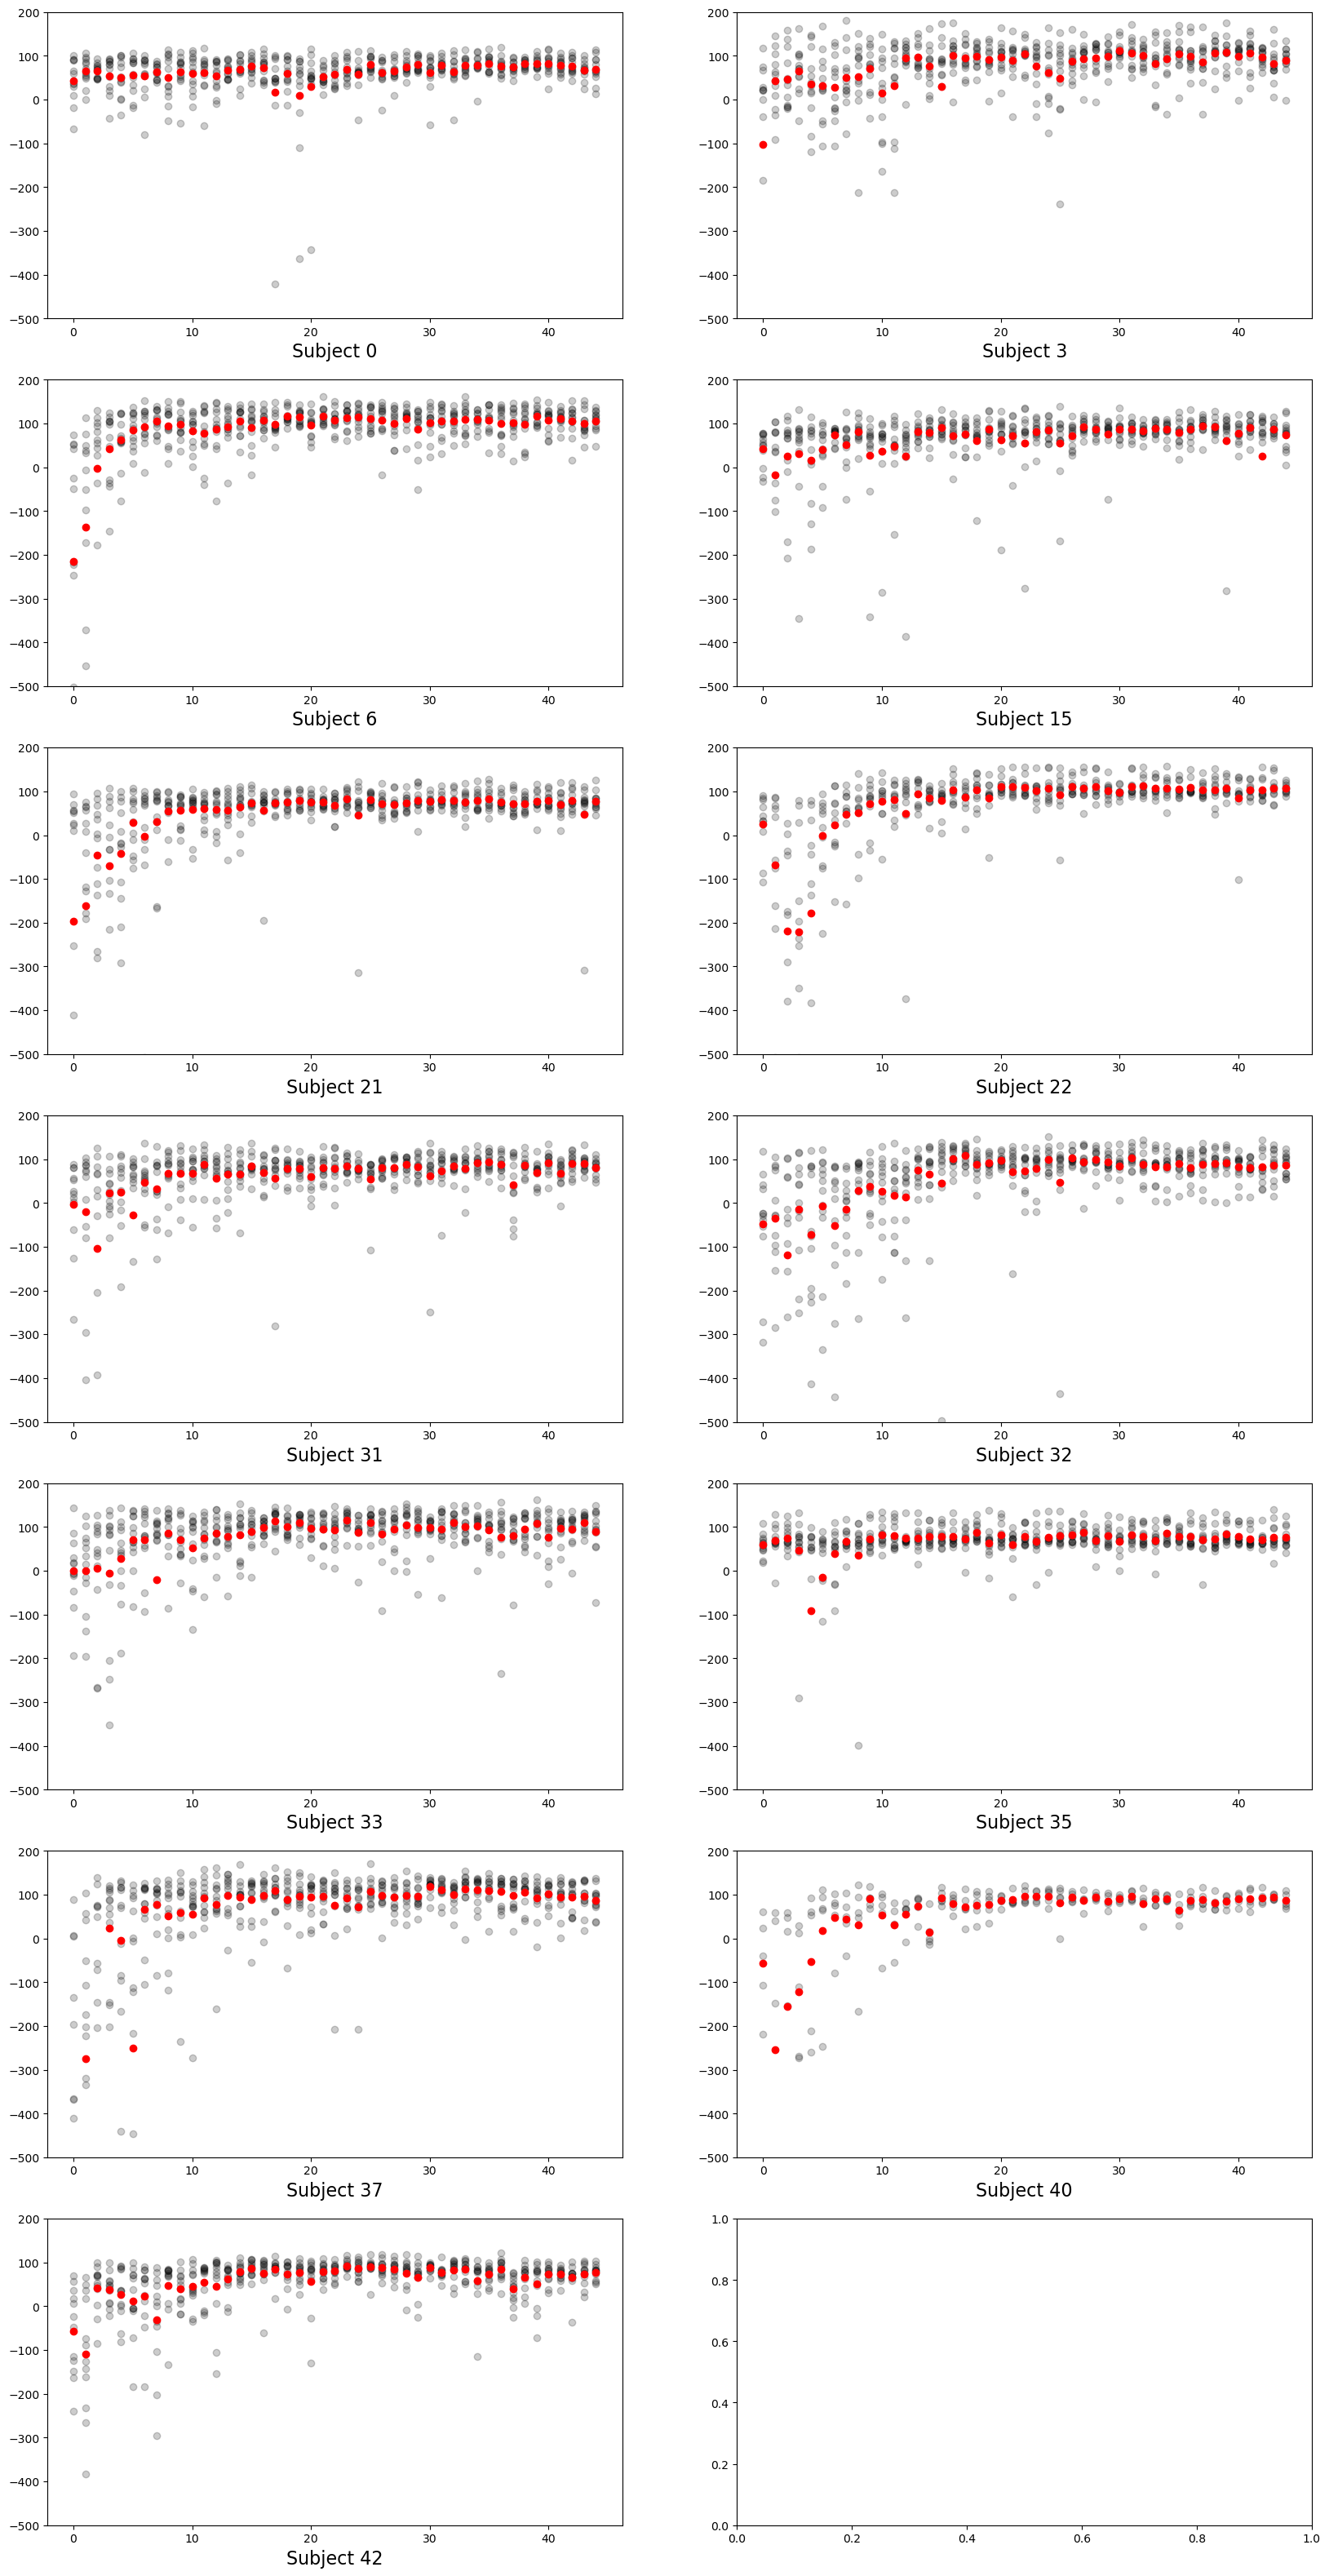

In [333]:
# subject, session, target, channel
# active_emg_mean.shape

fig, axes = plt.subplots(int(np.ceil(len(subject_subset) / 2)),2,figsize=(20,40))
axes = axes.ravel()

for axis_idx, (subject_idx, subject) in enumerate(zip(subject_subset_idxs, subject_subset)):
    subject_scores = np.empty(shape=(12,45))
    subject_scores[:] = np.nan
    for target_idx in range(12):
        he = hit_ends[subject_idx,:,target_idx,:]
        he = remove_nan_rows(he)

        pca = PCA(n_components=0.9)
        pca.fit(he)
        print(pca.components_.shape)

        em = active_emg_mean[subject_idx,:,target_idx,:]
        em, nan_idx = remove_nan_rows(em, return_idx=True)
        # print(em.dtype.char, np.typecodes['AllFloat'], np.isfinite(em).all(), count_nan(em))

        try:
            scores = pca.score_samples(em)
            subject_scores[target_idx,:] = scores
            axes[axis_idx].plot(scores, "ko", alpha=0.2)
        except:
            # print(subject_idx, target_idx)
            # print(active_emg_mean[subject_idx,:,target_idx,:])
            pass

        for ni in nan_idx:
            scores = insert_into_1d(scores, ni, np.nan)

    axes[axis_idx].plot(np.nanmean(subject_scores,axis=0),"ro")
    axes[axis_idx].set_ylim([-500,200])
    axes[axis_idx].set_xlabel(f"Subject {subject_idx}")


## load the natural movement dataset

### example single subject natural movement

In [217]:
filenames = get_movement_filenames("emg_olympics", subjects[25].name, "natural_movement", "session_0")
print(filenames[3])
emg = load_movement_emg(filenames[6])
filtered = filter_emg(emg, subject.variance)
indices, low_point, mean_norm_threshold = find_nat_movement_active_indices(filtered)

/Users/spencer/motor-control/data/rawdata/emg_olympics/lucas/natural_movement/session_0/middle finger up_2021_09_28_10_34.bin


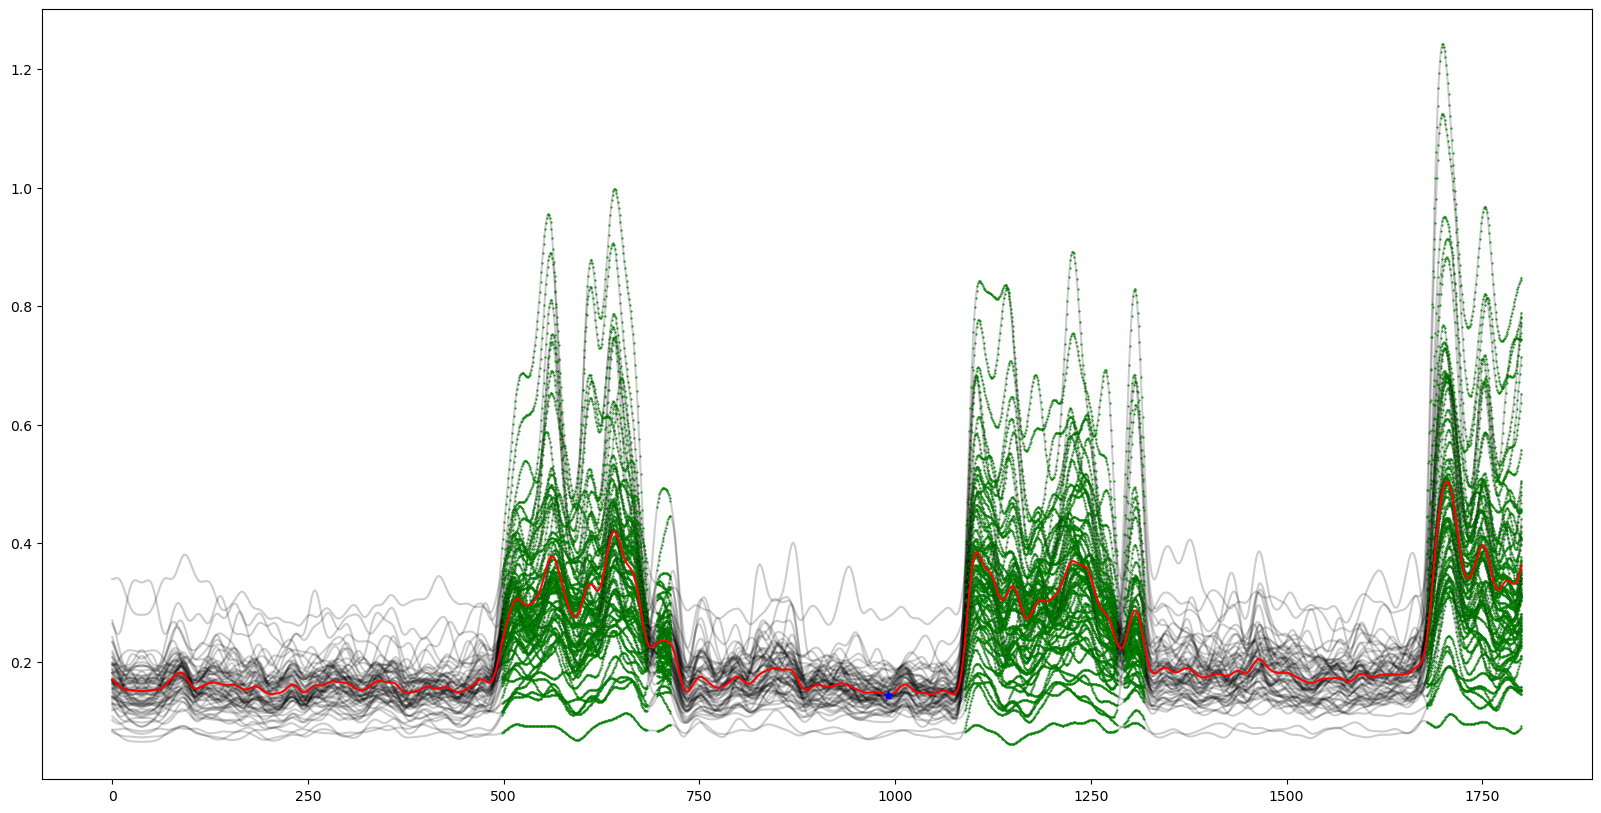

In [218]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

for channel in range(64):
    ax.plot(filtered[:, channel], "k", alpha=0.2)
    ax.plot(indices, filtered[indices, channel], "g.", markersize=1)

mean_sig = np.mean(filtered,axis=1)
ax.plot(mean_sig, "r")
ax.plot(low_point, mean_sig[low_point], "b*")

## load and filter the movement emg stacks

In [92]:
# subject_movement_stacks = np.empty(shape=(len(subjects), 28, 64))
# subject_movement_stacks[:] = np.nan
# for subject_idx, subject in enumerate(subjects):
#     subject_movement_stacks[subject_idx,:,:] = load_movement_stack(subject)

### save the natural movement data stack (alphabetical subject order)

In [93]:
# np.save(Path.cwd() / "subject_natural_movement_stacks.npy", subject_movement_stacks)

In [222]:
subject_movement_stacks = np.load("subject_natural_movement_stacks.npy")
subject_movement_stacks.shape

(46, 28, 64)

## plot trial-averaged natural movements

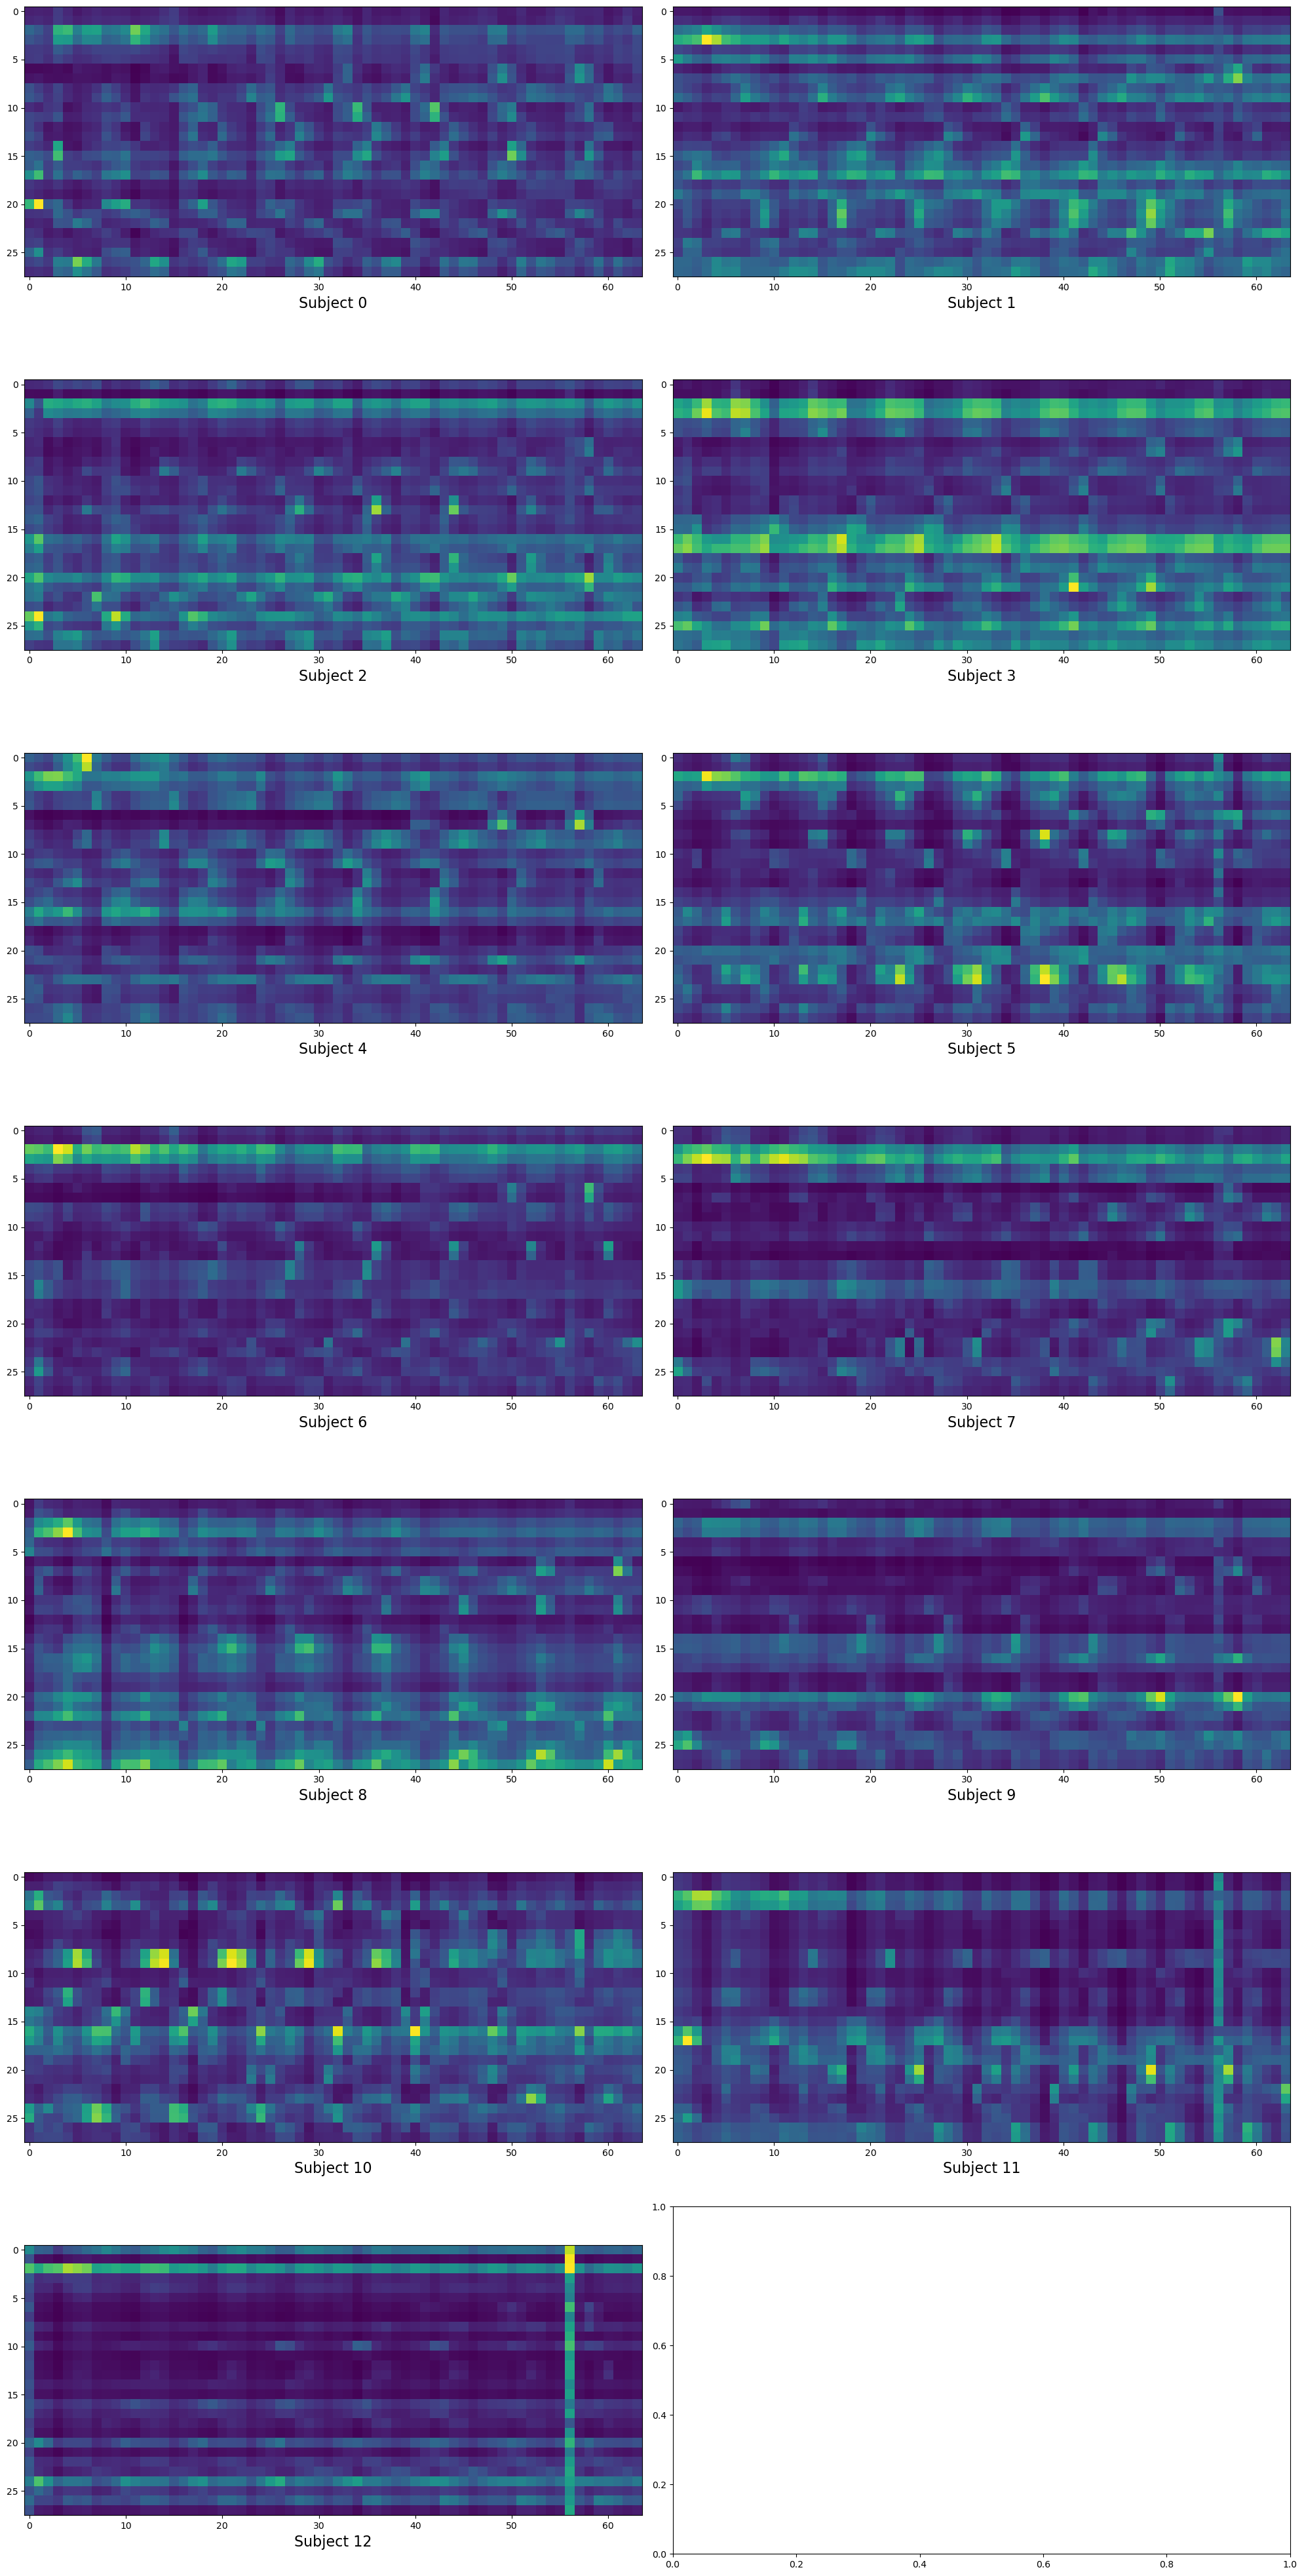

In [220]:
fig, axes = plt.subplots(int(np.ceil(len(subject_subset) / 2)),2,figsize=(20,40))
axes = axes.ravel()
for subject_idx, subject in enumerate(subject_subset):
    axes[subject_idx].imshow(subject_movement_stacks[subject_idx,:,:])
    axes[subject_idx].set_xlabel(f"Subject {subject_idx}")
fig.tight_layout()

## total variance of natural movement covariance

Text(0.5, 0, 'Hit Fraction')

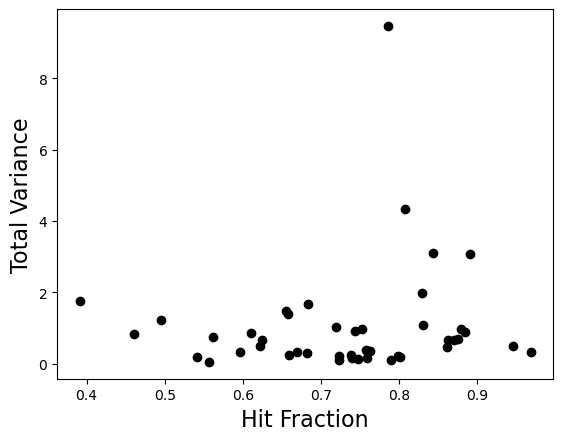

In [224]:
for subject_idx, subject in enumerate(subjects):
    plt.plot(hit_fractions[subject.name], np.trace(mean_zero_cov(subject_movement_stacks[subject_idx]))/64,"ko")
plt.ylabel("Total Variance")
plt.xlabel("Hit Fraction")

## PCA on the natural movement stacks, sample log-likelihoods for active emg in task trials

### plot the PCA model for natural movement

(0.0, 1.0)

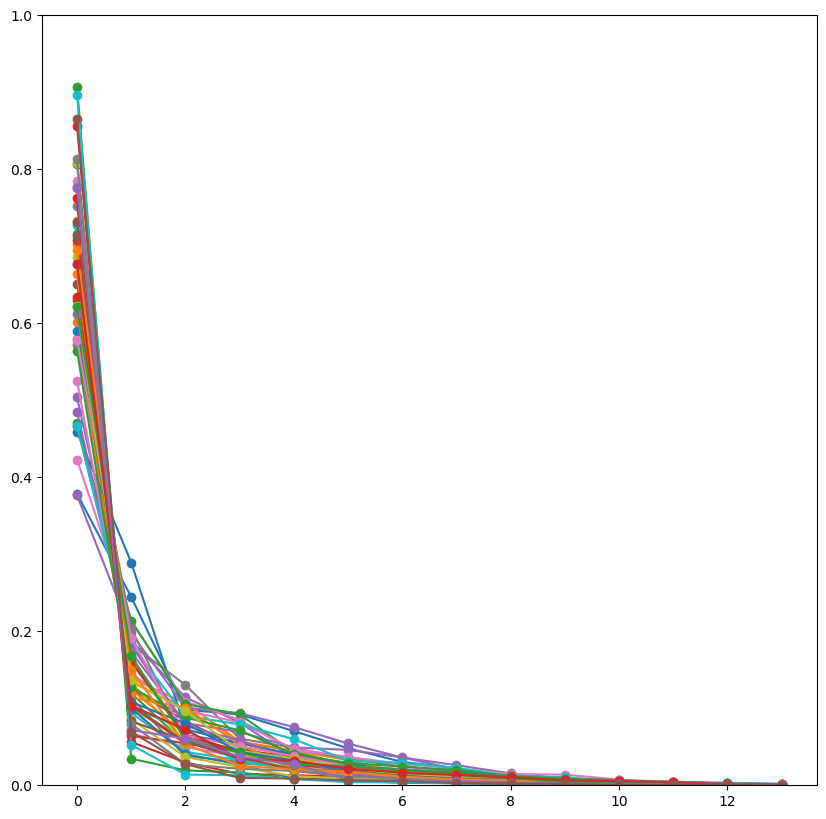

In [229]:
subject_movement_scores = np.empty(shape=(len(subjects),12,45))
subject_movement_scores[:] = np.nan
plt.figure(figsize=(10,10))
for subject_idx, subject in enumerate(subjects):
    subject_scores = np.empty(shape=(12,45))
    pca = PCA(n_components=14)
    stack = subject_movement_stacks[subject_idx,:,:]
    stack, nan_idx = remove_nan_rows(stack, return_idx=True)
    pca.fit(stack)
    plt.plot(pca.explained_variance_ratio_,"o-")
plt.ylim([0,1])

## top PC variance vs. hits?

## plot scores over trials, for each subject, means over targets

In [320]:
subject_movement_scores = np.empty(shape=(len(subjects),12,45))
subject_movement_scores[:] = np.nan
for subject_idx, subject in enumerate(subjects):
    subject_scores = np.empty(shape=(12,45))
    pca = PCA(n_components=2)
    stack = subject_movement_stacks[subject_idx,:,:]
    stack, nan_idx = remove_nan_rows(stack, return_idx=True)
    pca.fit(stack)
    # print(pca.components_.shape)
    for target_idx in range(12):
        em = active_emg_mean[subject_idx,:,target_idx,:]
        em, nan_idx = remove_nan_rows(em, return_idx=True)
        scores = pca.score_samples(em)
        if not len(nan_idx) == 0:
            for ni in nan_idx:
                scores = insert_into_1d(scores, ni, np.nan)
        subject_movement_scores[subject_idx,target_idx,:] = scores

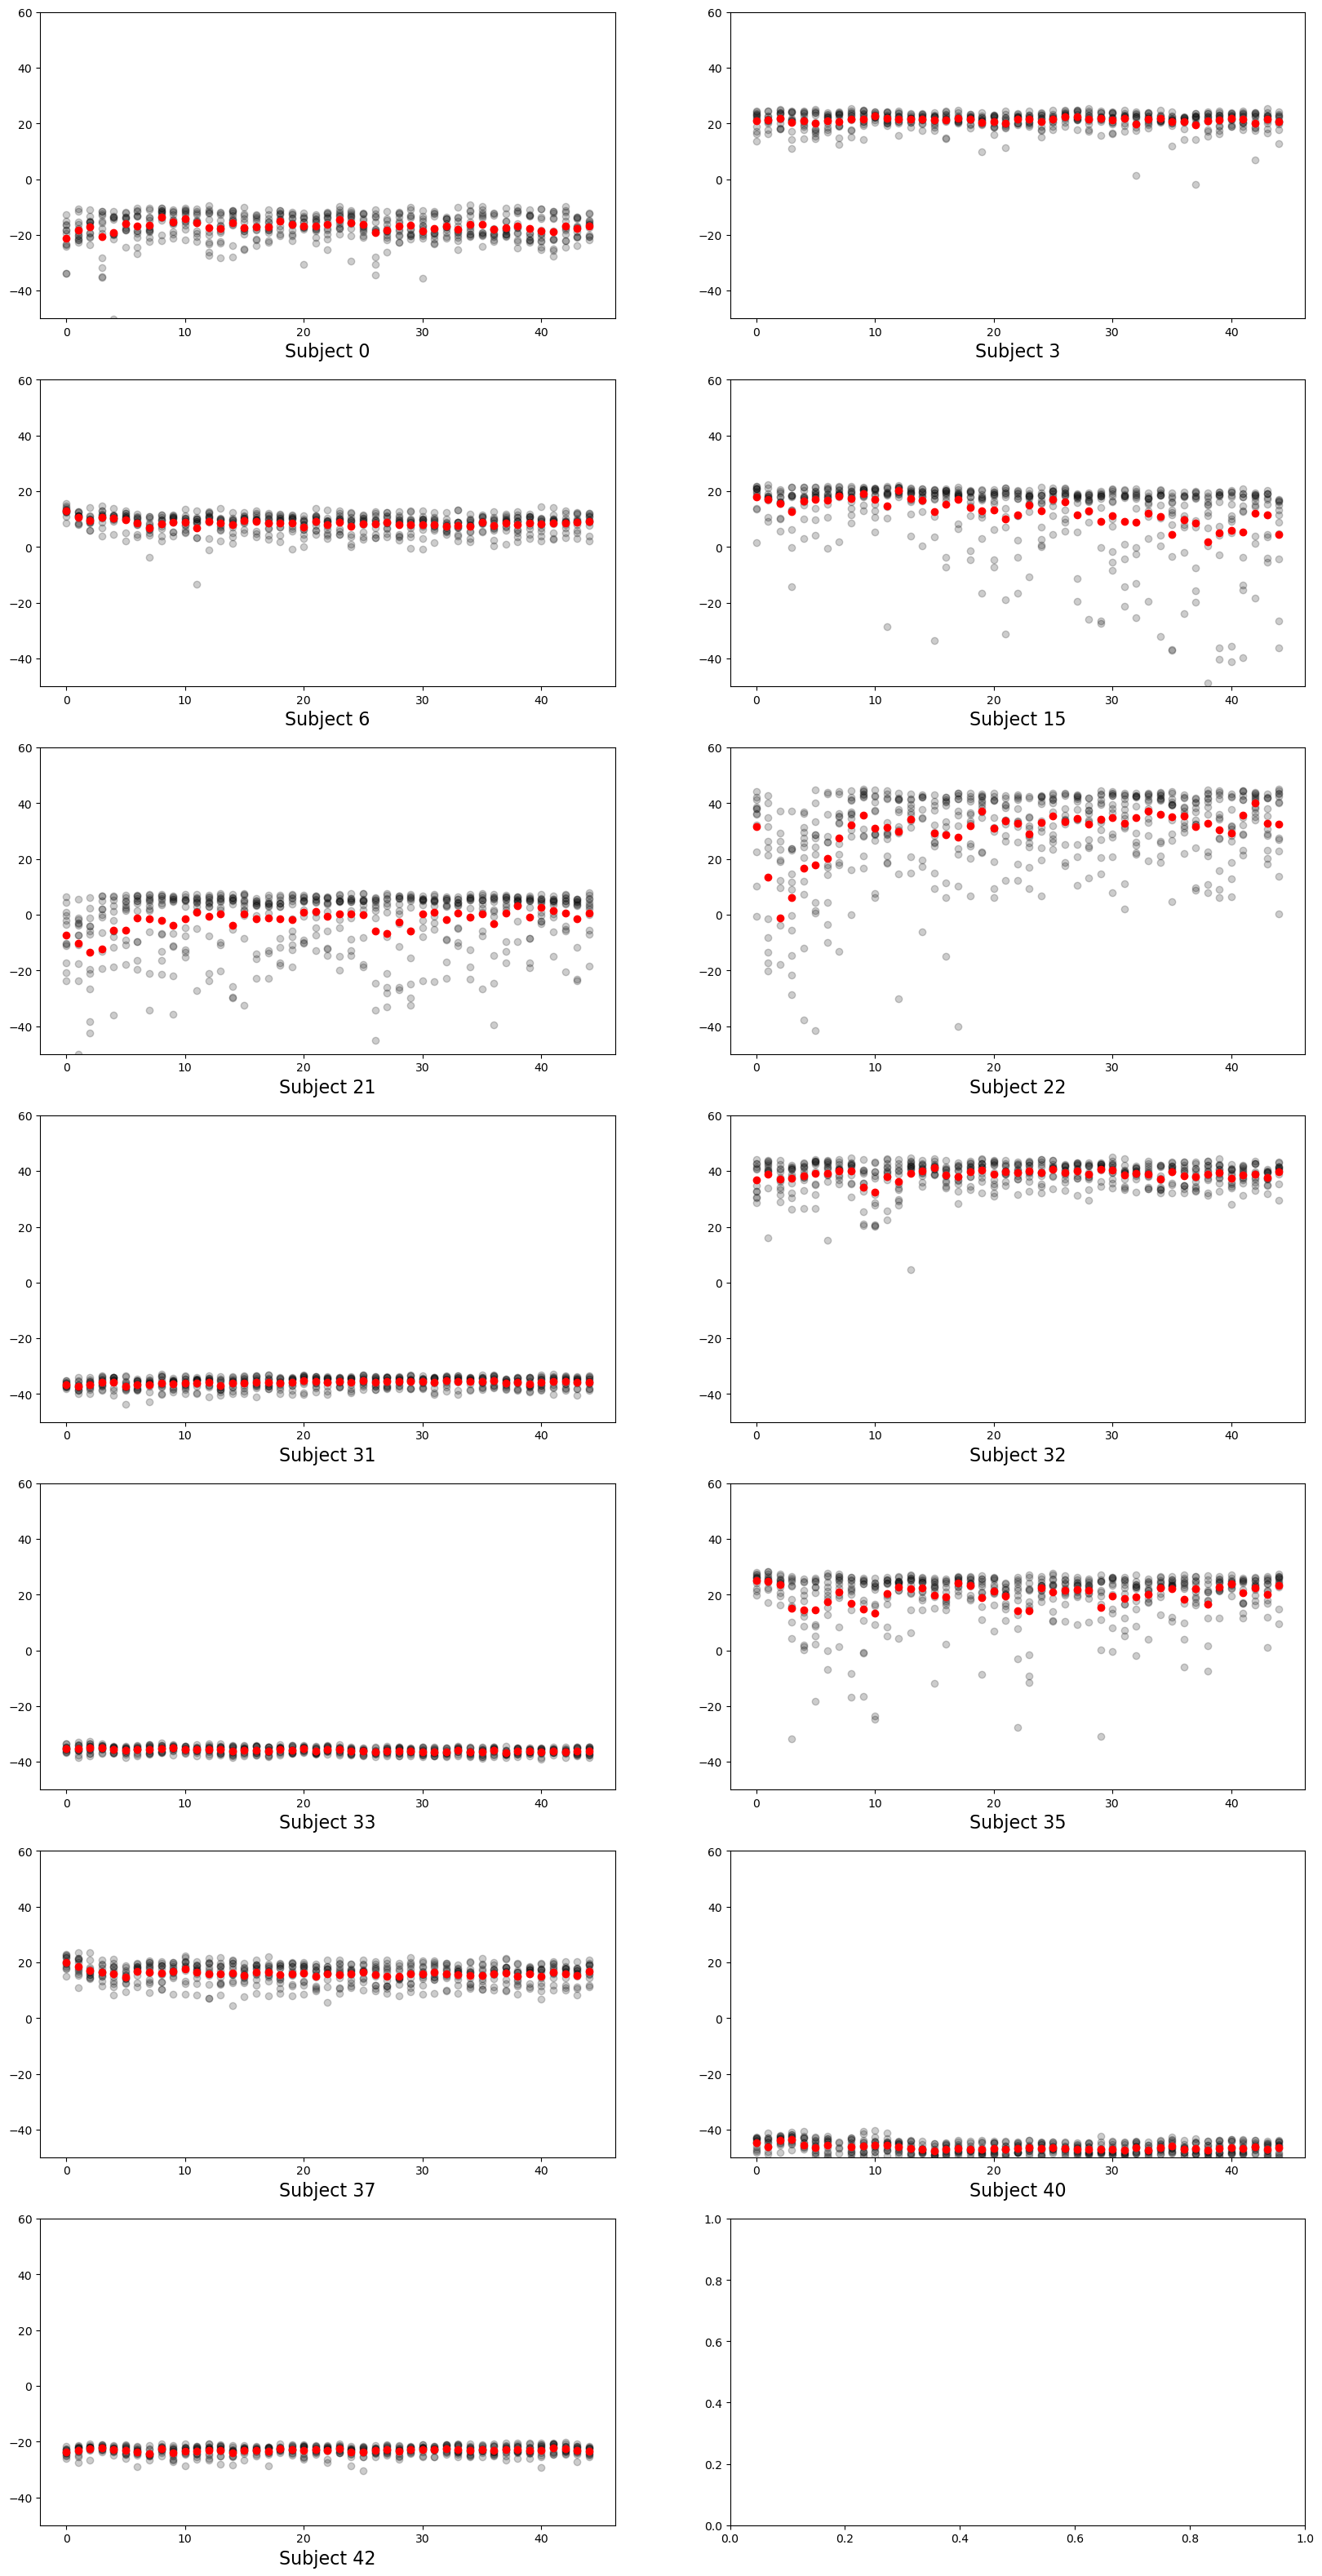

In [321]:
fig, axes = plt.subplots(int(np.ceil(len(subject_subset) / 2)),2,figsize=(20,40))
axes = axes.ravel()
for axis_idx, (subject_idx, subject) in enumerate(zip(subject_subset_idxs, subject_subset)):
    for target_idx in range(12):
        axes[axis_idx].plot(subject_movement_scores[subject_idx,target_idx], "ko", alpha=0.2)
    axes[axis_idx].plot(np.mean(subject_movement_scores[subject_idx],axis=0),"ro")
    axes[axis_idx].set_xlabel(f"Subject {subject_idx}")
    axes[axis_idx].set_ylim([-50,60])

## scores v. hits

[-1.70405579e+01  2.01372035e+00  3.24033757e+01  2.12368429e+01
  1.90326119e+01  1.10702972e+01  8.63189613e+00  3.02481893e+01
  2.48068366e+01  3.40093582e+01  5.29874892e+00  3.71766075e+01
 -1.09381329e+02 -7.63761986e+00 -3.62286302e+01  1.28469816e+01
  5.72806766e+00 -1.78634824e+01  3.65307465e+01 -2.21282355e+01
  2.13401513e+01 -1.95706544e+00  3.01036658e+01 -1.26719649e+01
 -3.30820556e+01  2.29528150e+00  4.94202508e+00  5.06874016e+01
 -8.44774331e+00  1.88634431e+01  4.31387946e+01 -3.59071518e+01
  3.87669847e+01 -3.59079671e+01 -2.29781497e+01  1.99441932e+01
 -8.39098141e+01  1.60880051e+01  2.10830568e+00  1.97023936e+01
 -4.64836826e+01  1.15287365e+00 -2.30942555e+01  2.78320841e+01
  3.91500220e+01 -1.25416112e+03]


Text(0, 0.5, 'Mean Sample Log-Likelihood under Natural Movement Model')

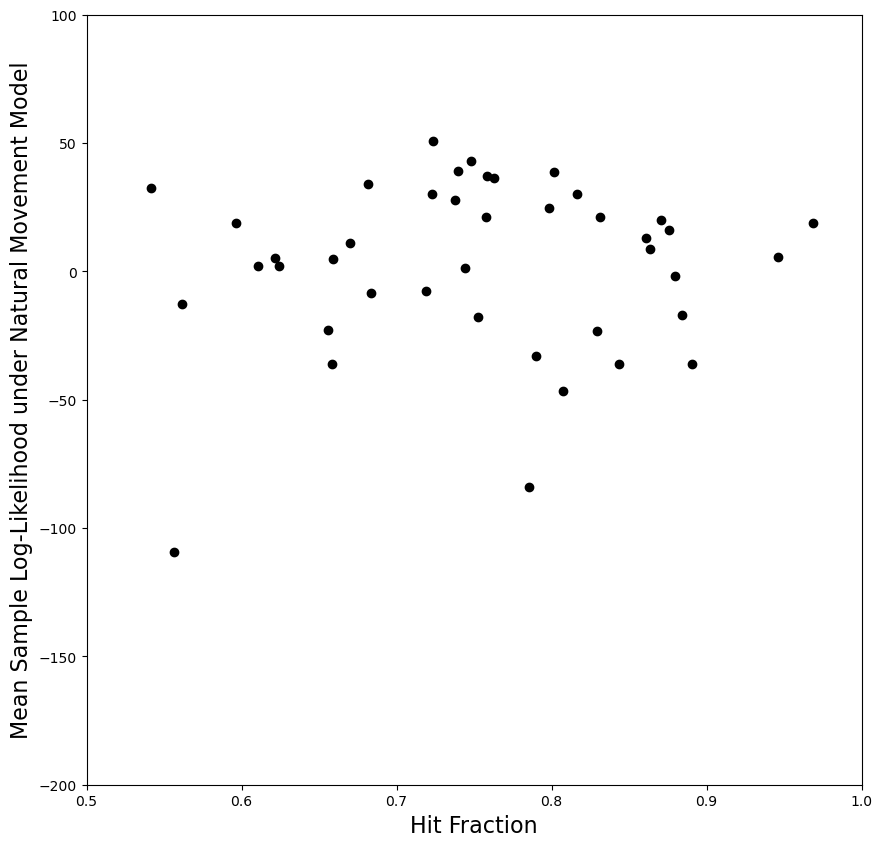

In [328]:
all_mean_scores = np.nanmean(subject_movement_scores,axis=(1,2))
print(all_mean_scores)
plt.figure(figsize=(10,10))
plt.plot(hit_fraction_list, all_mean_scores, "ko")
plt.xlim([0.5,1])
plt.ylim([-200,100])
plt.xlabel("Hit Fraction")
plt.ylabel("Mean Sample Log-Likelihood under Natural Movement Model")